Introduction 

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)



## EDA

In [36]:
import pandas as pd 
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv("icml_face_data.csv")


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


the pixels columns is a string and needs to converted to numeric

In [4]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
df.shape

(35887, 3)

array([[<AxesSubplot: title={'center': 'emotion'}>]], dtype=object)

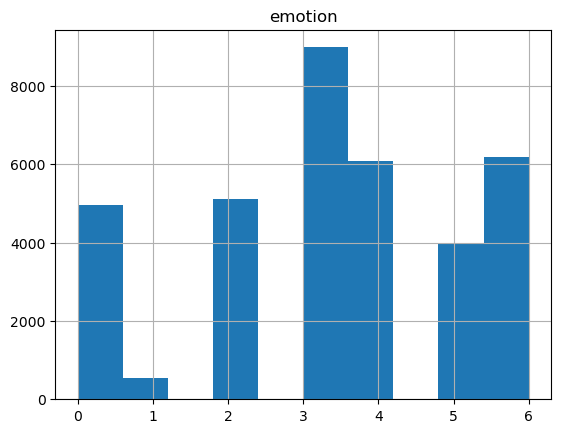

In [6]:
df.hist()

training category

In [7]:
df.loc[df[' Usage'] == 'Training'].shape

(28709, 3)

In [8]:
df.loc[df[' Usage'] == 'Training'].emotion.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

training category

In [9]:
df.loc[df[' Usage'] == 'PublicTest'].shape

(3589, 3)

In [10]:
df.loc[df[' Usage'] == 'PublicTest'].emotion.value_counts()

3    895
4    653
6    607
2    496
0    467
5    415
1     56
Name: emotion, dtype: int64

private test

In [11]:
df.loc[df[' Usage'] == 'PrivateTest'].shape

(3589, 3)

In [12]:
df.loc[df[' Usage'] == 'PrivateTest'].emotion.value_counts()

3    879
6    626
4    594
2    528
0    491
5    416
1     55
Name: emotion, dtype: int64

In [13]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

## Data Wrangling 

In [14]:
# Function that inputs a series of numerical strings separated
# by a " " and returns a numpy array 

def convert_to_numpy(x):
   
    pixel_arr = []
    
    # convert string to a list of strings
    pixels_list=x.str.split(' ')

    for _ in pixels_list:
        pixel_arr.append(pd.to_numeric(_))

    pixels_num = np.array(pixel_arr)

    return pixels_num

the square root of 2304 is 48, so the pixels need to be reshapped into 48 X 48 using the reshape method

drop group 1

So the training dataset is unbalanced in regards to the 1 and 3 categories. These need to be rebalanced using some translation, etc of the data that is avalaible.

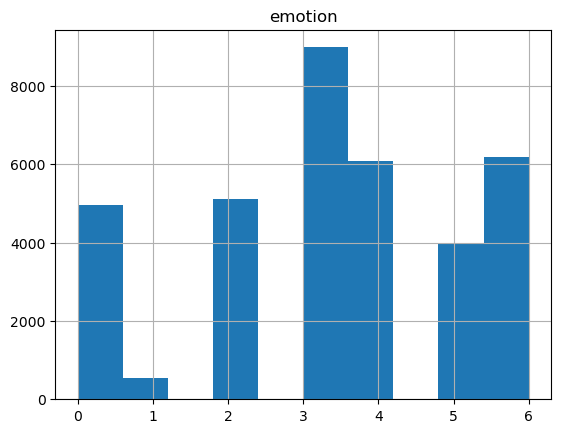

In [15]:
df.hist();

In [16]:
df.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [17]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

the label 1 needs to be dropped since there are not that many training examples

In [18]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [19]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [20]:
train_df = df.loc[df[' Usage'] == 'Training']

In [21]:
train_df

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
28704,2,Training,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,Training,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,Training,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,Training,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [22]:
train_df = train_df.drop([' Usage'], axis=1)

if we drop this row we need to recode the categorize so for now we will leave it

In [23]:
train_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [24]:
valid_df = df.loc[df[' Usage'] == 'PrivateTest']

In [25]:
valid_df = valid_df.drop(' Usage', axis=1)

In [26]:
valid_df.head()

,emotion,pixels
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...


In [27]:
# Separate out our target values
y_train = train_df['emotion']
y_valid = valid_df['emotion']

# Separate out our image vectors
x_train = convert_to_numpy(train_df[' pixels'])
x_valid = convert_to_numpy(valid_df[' pixels'])

# Turn our scalar targets into binary categories
num_classes = 7
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)



In [29]:
x_train

array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 74,  81,  87, ..., 188, 187, 187],
       [222, 227, 203, ..., 136, 136, 134],
       [195, 199, 205, ...,   6,  15,  38]], dtype=int64)

In [30]:
# Normalize our image data
x_train = np.divide(x_train, 255)
x_valid = np.divide(x_valid, 255)

In [31]:
x_train

array([[0.2745098 , 0.31372549, 0.32156863, ..., 0.41568627, 0.42745098,
        0.32156863],
       [0.59215686, 0.58823529, 0.57647059, ..., 0.75686275, 0.71764706,
        0.72156863],
       [0.90588235, 0.83137255, 0.61176471, ..., 0.34509804, 0.43137255,
        0.59607843],
       ...,
       [0.29019608, 0.31764706, 0.34117647, ..., 0.7372549 , 0.73333333,
        0.73333333],
       [0.87058824, 0.89019608, 0.79607843, ..., 0.53333333, 0.53333333,
        0.5254902 ],
       [0.76470588, 0.78039216, 0.80392157, ..., 0.02352941, 0.05882353,
        0.14901961]])

set a certain range for train_test_split

In [32]:
x_train = x_train.reshape(-1,48,48,1)
x_valid = x_valid.reshape(-1,48,48,1)

In [33]:
x_train

array([[[[0.2745098 ],
         [0.31372549],
         [0.32156863],
         ...,
         [0.20392157],
         [0.16862745],
         [0.16078431]],

        [[0.25490196],
         [0.23921569],
         [0.22745098],
         ...,
         [0.21960784],
         [0.20392157],
         [0.17254902]],

        [[0.19607843],
         [0.16862745],
         [0.21176471],
         ...,
         [0.19215686],
         [0.21960784],
         [0.18431373]],

        ...,

        [[0.35686275],
         [0.25490196],
         [0.16470588],
         ...,
         [0.28235294],
         [0.21960784],
         [0.16862745]],

        [[0.30196078],
         [0.32156863],
         [0.30980392],
         ...,
         [0.41176471],
         [0.2745098 ],
         [0.18039216]],

        [[0.30196078],
         [0.28235294],
         [0.32941176],
         ...,
         [0.41568627],
         [0.42745098],
         [0.32156863]]],


       [[[0.59215686],
         [0.58823529],
         [0.57

## Creating the Convolution Model Layers

In [46]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [47]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

AttributeError: module 'tensorflow' has no attribute 'Session'

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

## Data Augmentation

can vary minibatch sizes use hyperparmeter schedules 

vary learning rate with hyperparameter schedules 

the vision transformer. what is a transformer? token sequences 

timm hugging face models(pytorch image models)

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

## Batch Size 

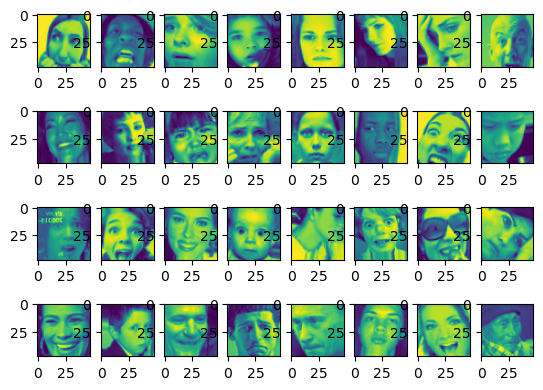

In [40]:
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## Fit Data to the Generator 

In [41]:
datagen.fit(x_train)

## Compiling the model

In [44]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.fit(img_iter,
          epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/20
897/897 [==============================] - 72s 78ms/step - loss: 1.7834 - accuracy: 0.3070 - val_loss: 1.7428 - val_accuracy: 0.2965
Epoch 2/20
897/897 [==============================] - 71s 79ms/step - loss: 1.5606 - accuracy: 0.3942 - val_loss: 1.5941 - val_accuracy: 0.4199
Epoch 3/20
897/897 [==============================] - 70s 78ms/step - loss: 1.4802 - accuracy: 0.4291 - val_loss: 1.4616 - val_accuracy: 0.4444
Epoch 4/20
479/897 [===============>..............] - ETA: 30s - loss: 1.4481 - accuracy: 0.4474

KeyboardInterrupt: 